# Imports

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fl
import os, sys, json
%load_ext autoreload
%autoreload 2

DATA_DIR = 'data/'

In [2]:
unemployment = pd.read_csv(DATA_DIR  + 'unemployment_data.csv')
unemployment = unemployment[['GEO', 'Value']]
unemployment = unemployment.rename(columns={'GEO': 'country', 'Value': 'unemp'})
country_geo = os.path.join('topojson', 'europe.topojson.json')

In [3]:
# Manually change 'UK' to 'GB' because topojson using 'GB'
unemployment.loc[unemployment['country'] == 'UK', ['country']] = ['GB']
unemployment.head()

,country,unemp
0,EU28,8.6
1,EU27,8.5
2,EU15,9.1
3,EA19,10.0
4,EA18,10.1


In [4]:
# Read country_geo file
with open(country_geo) as f: country_geo_json = json.loads(f.read())

In [5]:
m = fl.Map(location=[46.57, 7.8], zoom_start=3)
m.choropleth(
    geo_data=country_geo_json,
    topojson='objects.europe',
    name='choropleth',
    data=unemployment,
    columns=['country', 'unemp'],
    key_on='feature.id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
)


fl.LayerControl().add_to(m)

m


# Task 2

Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

> HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.
Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

## Solution

### Explanation and assumptions

#### Explanations

For this task. We used the data from the amstat website and chose our features to be "unemployed (without job and looking for one)", "searching for a job (both unemployed and employed)" and "searching for a job while being employed".

Given these features and the unemployment rate by canton. We were able to deduce the size of the active population per canton and to plot 2 separate maps.
* The first one represents the unemployment rate per canton where the unemployment rate is: `searching for a job` / `active population`
* The second one represents the unemployment rate per canton where the unemployment rate is: `searching for a job while being unemployed` / `active population`

This shows two similar maps with a few differences explained below.

In the process of cleaning the data, we had to transform the data into numeric types (for numeric columns) and also had to manually compute a mapping of the names between the topoJSON canton codes and the names in the fetched data

#### Assumptions

* While retrieving the data, we had the choice between "Unemployment for young people", "unemployment" and "looking for a job". For this task, we do not use the dataset "unemployment for young people" because it's a subset of the "unemployment" dataset so we do not need it

* We assume (and actually verified) that people that currently have a job and are looking for a new one are  taken into account in the unemployment rate

### Data loading

We load the unemployment data and process it

In [6]:
# Name of the columns
columns_names = ['region', 'canton', 'unemp_rate', 'unemp', 'searching', 'searching_employed']
# columns to keep
columns_keep = ['Région linguistique', 'Canton', 'Total', 'Total.1', 'Total.2', 'Total.3']

swiss_unemployment = pd.read_csv(
    DATA_DIR + 'swiss_unemp.txt',
    usecols=columns_keep,
    skiprows=[1]
)

# Renaming of the columns and aggregation by cantons
swiss_unemployment.columns = columns_names
swiss_unemployment.head()

,region,canton,unemp_rate,unemp,searching,searching_employed
0,Suisse alémanique,Zurich,3.3,27'225,34'156,6'931
1,Suisse alémanique,Berne,2.4,13'658,18'385,4'727
2,Suisse alémanique,Lucerne,1.7,3'885,6'756,2'871
3,Suisse alémanique,Uri,0.6,112,257,145
4,Suisse alémanique,Schwyz,1.7,1'455,2'229,774


It is possible here to see that the `searching` feature is the sum of the `unemp` and `searching_employed` metrics

In [7]:
# Mapping of the code names in the topoJSON file and the data
name_to_code = {'Zurich':'ZH', 
                'Berne':'BE',
                'Lucerne':'LU',
                'Uri':'UR',
                'Schwyz':'SZ',
                'Obwald':'OW',
                'Nidwald':'NW',
                'Glaris':'GL',
                'Zoug':'ZG',
                'Fribourg':'FR',
                'Soleure':'SO',
                'Bâle-Ville':'BS',
                'Bâle-Campagne':'BL',
                'Schaffhouse':'SH',
                'Appenzell Rhodes-Extérieures':'AR',
                'Appenzell Rhodes-Intérieures':'AI',
                'St-Gall':'SG',
                'Grisons':'GR',
                'Argovie':'AG',
                'Thurgovie':'TG',
                'Tessin':'TI',
                'Vaud':'VD',
                'Valais':'VS',
                'Neuchâtel':'NE',
                'Genève':'GE',
                'Jura':'JU'}

In [8]:
swiss_unemployment.canton = swiss_unemployment.canton.map(name_to_code)

We load the TopoJSON of swiss cantons 

In [9]:
canton_topo = json.load(open('topojson/ch-cantons.topojson.json'))

## Unemployment rate by cantons

In [10]:
m = fl.Map(location=[46.9,8.4], zoom_start=8)
m.choropleth(
    geo_data=canton_topo,
    topojson='objects.cantons',
    name='choropleth',
    data=swiss_unemployment,
    columns=['canton', 'unemp_rate'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)'
)


fl.LayerControl().add_to(m)

m

## Unemployment rates by cantons without people already employed

We transform the columns that are strings into integers (to do so we must delete the quotes)

In [11]:
def remove_quotes(df, column_name):
    return df[column_name].str.replace("'", '')

In [12]:
swiss_unemployment['unemp'] = remove_quotes(swiss_unemployment, 'unemp')
swiss_unemployment['searching'] = remove_quotes(swiss_unemployment, 'searching')
swiss_unemployment['searching_employed'] = remove_quotes(swiss_unemployment, 'searching_employed')
swiss_unemployment[['unemp', 'searching', 'searching_employed']] = swiss_unemployment[['unemp','searching', 'searching_employed']].apply(pd.to_numeric)

In [13]:
swiss_unemployment['active_pop'] = swiss_unemployment['searching'] / (swiss_unemployment['unemp_rate'] / 100)
swiss_unemployment['unemp_rate_not_employed'] = swiss_unemployment['unemp'] / swiss_unemployment['active_pop'] * 100

In [14]:
m = fl.Map(location=[46.9, 8.4], zoom_start=8)
m.choropleth(
    geo_data=canton_topo,
    topojson='objects.cantons',
    name='choropleth',
    data=swiss_unemployment,
    columns=['canton', 'unemp_rate_not_employed'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)'
)


fl.LayerControl().add_to(m)

m

Here we can see that some cantons fall into different categories than the previous map. It means that the same data can be interpreted in various ways depending of the initial assumptions.

For example, here we see that Ticino has a similar unemployment rate than Valais and Berne, whereas this was not true in the first map. Same for Aargau, Solothurn, etc

# Task 4 (Bonus)

BONUS: using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

## Solution

#### Explanation

Using the data from task 2, it is possible to give a very precise unemployment rate for the 2 areas divided by the Röstigraben. We just need to group the data by linguistical region and plot the data

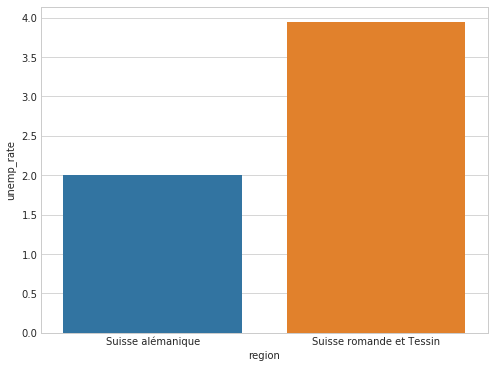

In [21]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

data = swiss_unemployment.groupby(by='region', as_index=False).mean()
sns.barplot(ax=ax, x="region", y="unemp_rate", data=data.drop(2))

In [ ]:
As we can see (and can predict from the maps), the swiss